# Main Calculation Restart Workflow

The `crystal17.main.base` workflow builds on the `crystal.main` calculation, by automating restarts of the calculation for known failure modes:

- **No SCF convergence within maximum cycles**: the FMIXING value is lowered, and the calculation is restarted from the last known geometry and wave-function (using GUESSP)
- **No geometric convergence within maximum iterations**: the calculation is restarted from the last known geometry and wave-function (using GUESSP)
- **Reaches scheduler wall-time**: the calculation is restarted from the last known geometry.

Additionally, new SHRINK terms can be computed, to adhere to a minimum desired k-point spacing, given the input structure.

In [1]:
!verdi status

 ✓ profile:     On profile test_crystal17
 ✓ repository:  /Users/cjs14/GitHub/aiida-cjs-working/databases/aiida/.aiida/repository/test_crystal17
 ✓ postgres:    Connected as cjs14@localhost:5432
 ✓ rabbitmq:    Connected to amqp://127.0.0.1?heartbeat=600
 ✓ daemon:      Daemon is running as PID 35477 since 2019-07-18 12:57:21


In [2]:
!verdi plugin list aiida.workflows crystal17.main.base

Inputs
                   cry:  required                 
          basis_family:  optional  Str            An alternative to specifying the basis sets manually: one can specify the n ...
         clean_workdir:  optional  Bool           If `True`, work directories of all called calculation will be cleaned at th ...
      kpoints_distance:  optional  Float          The minimum desired distance in 1/Å between k-points in reciprocal space. T ...
  kpoints_force_parity:  optional  Bool           Optional input when constructing the k-points based on a desired `kpoints_d ...
        max_iterations:  optional  Int            Maximum number of iterations the work chain will restart the calculation to ...
              metadata:  optional                 
Outputs
         remote_folder:  required  RemoteData     Input files necessary to run the process will be stored in this folder node ...
               results:  required  Dict           the data extracted from the main output file
        

In [15]:
import os

from aiida.engine import run_get_node
from aiida.plugins import (
    DataFactory, WorkflowFactory, CalculationFactory)
from aiida.tools.visualization import Graph

from aiida_crystal17.tests import get_test_structure_and_symm, TEST_FILES
from aiida_crystal17.tests.utils import get_default_metadata
from aiida_crystal17.tests.utils import get_or_create_local_computer, get_or_create_code

In [7]:
from aiida import load_profile
profile = load_profile()
profile.name

'test_crystal17'

In [8]:
DataFactory('crystal17.basisset')

aiida_crystal17.data.basis_set.BasisSetData

In [18]:
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.main', computer, 'mock_crystal17')

params = {
        "title": "NiO Bulk with AFM spin",
        "scf.single": "UHF",
        "scf.k_points": (8, 8),
        "scf.spinlock.SPINLOCK": (0, 15),
        "scf.numerical.FMIXING": 50,
        "scf.numerical.MAXCYCLE": 10,
        "scf.post_scf": ["PPAN"]
    }

instruct, symmetry = get_test_structure_and_symm("NiO_afm")

kind_data = DataFactory('crystal17.kinds')(data={
    "kind_names": ["Ni1", "Ni2", "O"],
    "spin_alpha": [True, False, False], "spin_beta": [False, True, False]})

DataFactory('crystal17.basisset').upload_basisset_family(
        os.path.join(TEST_FILES, "basis_sets", "sto3g"),
        "sto3g",
        "minimal basis sets",
        stop_if_existing=False,
        extension=".basis")

# set up calculation
process_class = code.get_builder().process_class
calc_builder = process_class.create_builder(
    params, instruct, "sto3g", 
    symmetry=symmetry, 
    kinds=kind_data, 
    code=code,
    metadata=get_default_metadata(),
    unflatten=True)

wc_builder = WorkflowFactory('crystal17.main.base').get_builder()
wc_builder.cry = dict(calc_builder)
wc_builder.clean_workdir = True

In [19]:
outputs, wc_node = run_get_node(wc_builder)

In [25]:
!verdi process status {wc_node.pk}

CryMainBaseWorkChain<240> Finished [5:results]
    ├── CryMainCalculation<242> Finished [411]
    └── CryMainCalculation<247> Finished [0]


In [26]:
!verdi process report {wc_node.pk}

2019-07-18 13:02:05 [20 | REPORT]: [240|CryMainBaseWorkChain|run_calculation]: launching CryMainCalculation<242> iteration #1
2019-07-18 13:02:19 [23 | REPORT]: [240|CryMainBaseWorkChain|report_error_handled]: CryMainCalculation<242> failed with exit status 411: SCF convergence did not finalise (usually due to reaching step limit)
2019-07-18 13:02:19 [24 | REPORT]: [240|CryMainBaseWorkChain|report_error_handled]: Action taken: reduced fmixing from 50 to 40 and restarting from last calculation
2019-07-18 13:02:20 [25 | REPORT]: [240|CryMainBaseWorkChain|run_calculation]: launching CryMainCalculation<247> iteration #2
2019-07-18 13:02:30 [26 | REPORT]: [240|CryMainBaseWorkChain|inspect_calculation]: CryMainCalculation<247> completed successfully
2019-07-18 13:02:30 [27 | REPORT]: [240|CryMainBaseWorkChain|results]: work chain completed after 2 iterations
2019-07-18 13:02:30 [28 | REPORT]: [240|CryMainBaseWorkChain|on_terminated]: cleaned remote folders of calculations: 242 247


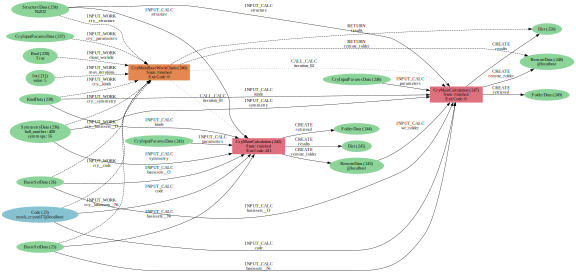

In [24]:
graph = Graph(graph_attr={'size': "8,8!", "rankdir": "LR"})
graph.recurse_descendants(
    wc_node, annotate_links="both",
    include_process_inputs=True
)
graph.graphviz